# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Imad"
ln1 = "Al_moslli"
fn2 = "Adnan"
ln2 = "Asadullah"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_al_moslli_imad_and_asadullah_adnan.ipynb


In [0]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [0]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [0]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)
n_iter=10000
A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [0]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += np.dot(A[:,j].T,residuals)/lips_const[j]
        # update residuals:
        residuals += np.dot(A[:,j],old_w_j-w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j =w[j] 
        w[j] -= (1/lips_const[j])*gradient[j]
        # update gradient:
        gradient +=gram[:,j].dot((w[j]-old_w_j)) 
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- from a practical point of view, could you use greedy CD for ridge logistic regression? to solve OLS, but with 100,000 features? Explain your answers.

In [0]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [0]:
from time import time

class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [0]:
from scipy.optimize import fmin_l_bfgs_b

def loss(w,A,b):
  return (1/2)*np.linalg.norm(np.dot(A,w)-b)**2

def grad(w,A,b):
  return np.dot(A.T,np.dot(A,w)-b)

x_init = np.zeros(n_features)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)

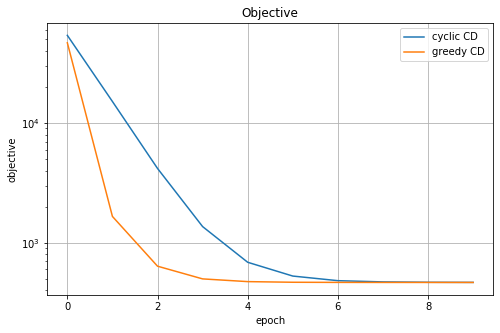

In [9]:
w_cyclic, all_objs_cyclic = cyclic_cd(A, b, 1000)
w_greedy, all_objs_greedy = greedy_cd(A, b, 1000)

plt.figure(figsize=(8, 5))
plt.semilogy(all_objs_cyclic, label="cyclic CD")
plt.semilogy(all_objs_greedy, label="greedy CD")
plt.title('Objective')
plt.xlabel('epoch')
plt.ylabel('objective')
plt.grid()
plt.legend()

When can see that greedy CD requires less computation to converge even though it computes full gradient at each iteration. This is due to the fact that it is more efficient because it performs exact coordinate descent along the coordinate which maximizes the gradient while for cyclic CD, this coordinate choice is rather arbitrary.

We could not use greedy CD or even cyclic CD (exact CD in general) for unregularized logistic regression because it is non-smooth.

Because it requires to compute full gradient, greedy CD would not be necessarily adapted for OLS with 100,000 features. 

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Assuming uniqueness of the solution, show that:
$$ \lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

*answer here*

$
f(w)=\sum_{i=1}^nlog(1+e^{-y_iw^Tx_i}) = \sum_{i=1}^n f_i(w) \\
\nabla f(w) = -\sum_{i=1}^n \frac{y_ix_i}{1 + e^{-y_i w^\top x_i}} \\
$

$
\begin{align}
\hat w = 0 &\Leftrightarrow -\nabla f(0) \in \lambda \partial \Vert w \Vert_1 \\
&\Leftrightarrow \sum_{i=1}^n \frac{y_ix_i}{2} \in \lambda \partial \Vert w \Vert_1 \\
&\Leftrightarrow \sum_{i=1}^n \frac{y_ix_i}{2\lambda} \in \partial \Vert w \Vert_1 \\
&\Leftrightarrow \Vert \frac{X^Ty}{2\lambda} \Vert_{\infty} \in [-1, 1] & because && \partial \Vert \cdot \Vert_1 (\mathbf{0}_p)) = [-1, 1] \times \dots \times [-1, 1] \\
&\Leftrightarrow \frac{\lambda_{max}}{\lambda} \leq 1 \Leftrightarrow \lambda_{max} \leq \lambda
\end{align}
$



2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

*answer here*

$
\nabla f(w) = -\sum_{i=1}^n \frac{y_ix_i}{1 + e^{-y_i w^\top x_i}} \\
$

$
\begin{align}
\nabla^2 f(w) &= \sum_{i=1}^n \frac{y_i^2x_i^2e^{-y_i w^\top x_i}}{(1 + e^{-y_i w^\top x_i})^2} \\
&= \sum_{i=1}^n \frac{x_i^2e^{-w^\top x_i}}{(1 + e^{-w^\top x_i})^2} & if  &&y_i \in \{ -1, 1\}
\end{align}
$ 

$
\begin{align}
\nabla_j^2 f(w) &= \sum_{i=1}^n x_{i,j}^2 \overbrace{\frac{e^{-y_i w^\top x_i}}{(1 + e^{-y_i w^\top x_i})^2}}^{\leq 1/4} \\
&\leq \frac{\Vert X_j \Vert^2}{4} = \gamma_j
\end{align}
$ 


You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [0]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


In [0]:


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    # TODO
    lips_const = np.zeros(n_features)
    lips_const = (np.linalg.norm(X,axis=0)**2)/4
    all_objs = np.zeros(n_iter)
    # END TODO
    #print(n_iter)
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = np.sum(- y * X[:, j] * sigmoid(-y * Xw))
            #print(lips_const[j])
            w[j] = soft_thresh(w[j] - grad_j/lips_const[j] , lamb/lips_const[j])
            if old_w_j != w[j]:
               Xw += X[:,j].dot(w[j]-old_w_j)
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs


In [12]:
print(y.shape)
print(X.shape)

(1000,)
(1000, 100)


In [0]:

w_logreg , obj_logreg = cd_logreg(X, y, lamb, n_iter=100)

In [16]:
obj_logreg

array([441.85588087, 395.98118545, 383.59280552, 378.12157231,
       375.2545411 , 373.64035796, 372.72171366, 372.13556571,
       371.74842954, 371.48911748, 371.31249673, 371.19043127,
       371.10675888, 371.04814393, 371.00684571, 370.97756717,
       370.95669683, 370.94175311, 370.93101328, 370.92327085,
       370.9176747 , 370.91362087, 370.91069135, 370.90869594,
       370.90728527, 370.90627895, 370.90555842, 370.90504132,
       370.90466954, 370.90440184, 370.90420881, 370.90406946,
       370.90396875, 370.9038959 , 370.90384316, 370.90380494,
       370.90377723, 370.90375713, 370.90374253, 370.90373193,
       370.90372422, 370.90371861, 370.90371454, 370.90371157,
       370.90370941, 370.90370784, 370.90370669, 370.90370585,
       370.90370524, 370.9037048 , 370.90370447, 370.90370424,
       370.90370406, 370.90370394, 370.90370385, 370.90370378,
       370.90370373, 370.90370369, 370.90370367, 370.90370365,
       370.90370363, 370.90370362, 370.90370362, 370.90

No handles with labels found to put in legend.


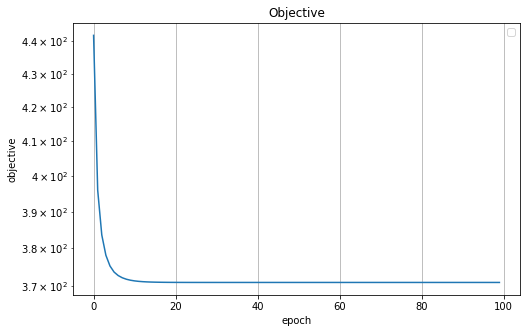

In [17]:
plt.figure(figsize=(8, 5))

plt.semilogy(obj_logreg)
plt.title('Objective')
plt.xlabel('epoch')
plt.ylabel('objective')
plt.grid()
plt.legend()


# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [0]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [19]:
print(X.shape)
n_samples, n_features = X.shape
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

**A simple proximal gradient solver for the Lasso**

In [0]:
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return (lmbd)*np.linalg.norm(x,ord=1)

In [0]:
def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)

In [0]:
def loss(Xw):
  """Ordinary Least Squares"""
  return (1/2)*np.linalg.norm(Xw-y, ord=2)**2

def grad(Xw):
  """Ordinary Least Squares"""
  return np.dot(X.T,Xw-y)

In [0]:
def PGD(f, grad_f, R, prox_R, lips, lmbd=0., n_iter=50):
    """Proximal gradient descent algorithm"""
    w = np.zeros(n_features)
    # objective history
    objectives = []
    print(X.shape)
    # Current objective
    Xw = X.dot(w)
    obj = f(Xw) + R(w, lmbd)
    objectives.append(obj)
    for k in range(n_iter):
        #### TODO ####
        w = prox_R(w - (1/lips) * grad_f(Xw), lmbd/lips)
        Xw = X.dot(w) 
        obj = f(Xw) + R(w, lmbd)
        objectives.append(obj)

    return w, objectives

# **CD**

In [0]:
def cd(X, y, lamb, n_iter,f,R,prox_R=soft_thresh):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)

    Xw = X.dot(w)
    # TODO
    lips_const = np.linalg.norm(X,axis=0)**2
    all_objs = np.zeros(n_iter)
    all_objs[0] = f(Xw) + R(w, lamb)
    # END TODO
    #print(n_iter)
    for t in range(n_iter-1):
        for j in range(n_features):
            old_w_j = w[j]
            
            # TODO
            grad_j = np.dot(X[:,j], Xw-y)
            w[j] = prox_R(w[j] - grad_j/lips_const[j] , lamb/lips_const[j]) 
            
            if old_w_j != w[j]:
               Xw += X[:,j].dot(w[j]-old_w_j)
            #END TODO
            
        all_objs[t+1] = f(Xw) + R(w, lamb)
    
    return w, all_objs

In [26]:
n_features=X.shape[1]
lips= np.linalg.norm(X, ord=2) ** 2

w_PGD , objec_PGD = PGD( f=loss, grad_f=grad, R=L1_norm, prox_R=soft_thresh, lips=lips, lmbd=lambd, n_iter=30)
w_CD , objec_CD =cd(X, y, lambd, n_iter=30,f=loss,R=L1_norm,prox_R=soft_thresh)

(72, 7129)


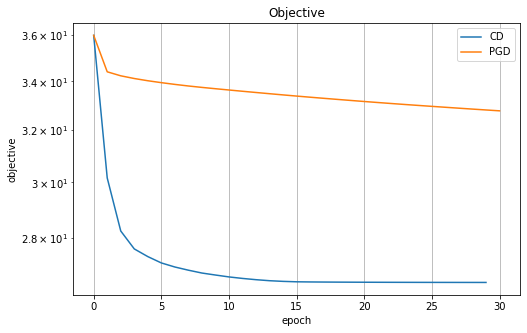

In [27]:
plt.figure(figsize=(8, 5))

plt.semilogy(objec_CD, label="CD")
plt.semilogy(objec_PGD, label="PGD")
plt.title('Objective')
plt.xlabel('epoch')
plt.ylabel('objective')
plt.grid()
plt.legend()


We can see above that proximal coordinate descent converges faster than proximal gradient descent.

Indeed, for the gradiant descent to converge, we need :
$\frac{L(\nabla f)}{2(k+1)}||x_* - x_0||_2^2$ while for coordianate descent, we need $\frac{n}{\epsilon}( (1 - \frac{1}{n}) (f(x_0) - f(x_*)) + \frac{1}{2} ||x_* - x_0||_L^2)$ and the cost of an iteration is lower and may be divided by the number of features compared to GD.

